# CellDISECT Counterfactual Analysis

In [1]:
!pip install celldisect==0.2.0b1
!pip install torchvision==0.16.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of scvi-tools to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numpyro to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pydantic to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.8/170.8 k

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

from celldisect import CellDISECT
import scvi
scvi.settings.seed = 42
import scanpy as sc
from anndata import AnnData
import os
import shutil
import gc
import anndata as ad
import pandas as pd
from scipy.stats import pearsonr
import numpy as np


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [3]:
import gdown
gdown.download('https://drive.google.com/uc?export=download&id=1z8gGKQ6oDoi2blCU2IVihKA38h5fORRp')
data_path = 'kang_normalized_hvg.h5ad'
adata = sc.read(data_path)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1z8gGKQ6oDoi2blCU2IVihKA38h5fORRp
From (redirected): https://drive.google.com/uc?export=download&id=1z8gGKQ6oDoi2blCU2IVihKA38h5fORRp&confirm=t&uuid=79a4319e-0cde-4eff-bf50-96c696868fc2
To: /content/kang_normalized_hvg.h5ad
100%|██████████| 545M/545M [00:05<00:00, 93.8MB/s]


In [4]:
adata

AnnData object with n_obs × n_vars = 13576 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'cov_cond', 'split_CD14 Mono', 'split_CD4 T', 'split_T', 'split_CD8 T', 'split_B', 'split_DC', 'split_CD16 Mono', 'split_NK'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol'
    uns: 'hvg', 'log1p', 'rank_genes_groups_cov'
    layers: 'counts'

In [5]:
adata.X.min(), adata.X.max()

(0.0, 9.887986)

In [6]:
adata.X = adata.layers['counts'].copy()
adata.X.min(), adata.X.max()

(0.0, 3828.0)

In [7]:
# Normalizing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [8]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 13576 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'cov_cond', 'split_CD14 Mono', 'split_CD4 T', 'split_T', 'split_CD8 T', 'split_B', 'split_DC', 'split_CD16 Mono', 'split_NK'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol'
    uns: 'hvg', 'log1p', 'rank_genes_groups_cov', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

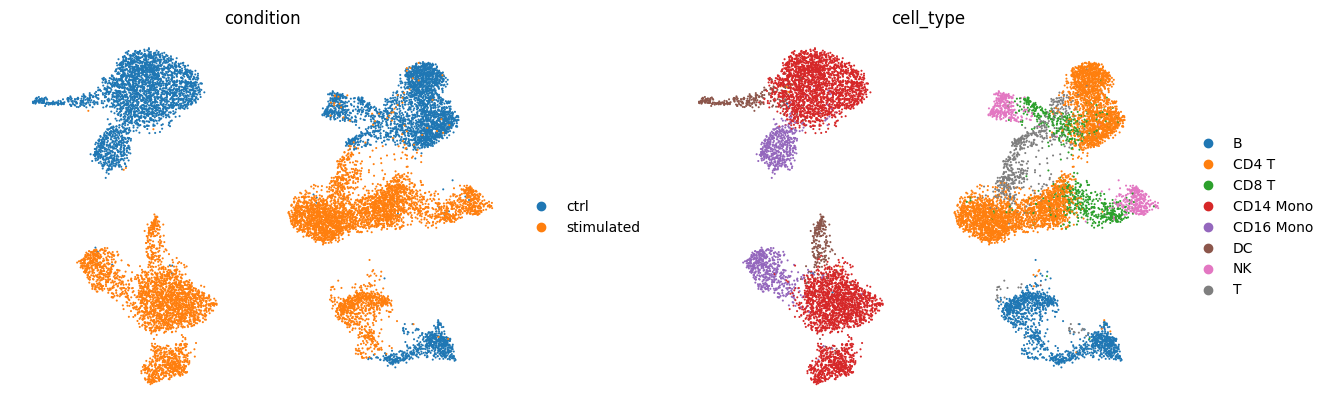

In [9]:
sc.pl.umap(
    adata,
    color=['condition', 'cell_type'],
    frameon=False,
    # legend_loc=None,
    wspace=0.2,
    )

In [10]:
cats = ['cell_type', 'condition']

In [11]:
adata.X = adata.layers['counts'].copy()
adata = adata[adata.X.sum(1) != 0].copy()
adata.X.min(), adata.X.max()

(0.0, 3828.0)

In [12]:
cell_type_included = True # Set to True if you have provided a cell type annotation in the cats list

module_name = 'Kang'
pre_path = f'drive/MyDrive/cellDISECT/models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

arch_dict = {'n_layers': 2,
 'n_hidden': 128,
 'n_latent_shared': 32,
 'n_latent_attribute': 32,
 'dropout_rate': 0.1,
 'weighted_classifier': True,
}
train_dict = {
 'max_epochs': 1000,
 'batch_size': 256,
 'recon_weight': 20,
 'cf_weight': 0.8,
 'beta': 0.003,
 'clf_weight': 0.05,
 'adv_clf_weight': 0.014,
 'adv_period': 5,
 'n_cf': 1,
 'early_stopping_patience': 6,
 'early_stopping': True,
 'save_best': True,
 'kappa_optimizer2': False,
 'n_epochs_pretrain_ae': 0,
}

plan_kwargs = {
 'lr': 0.003,
 'weight_decay': 0.00005,
 'ensemble_method_cf': True,
 'lr_patience': 5,
 'lr_factor': 0.5,
 'lr_scheduler_metric': 'loss_validation',
 'n_epochs_kl_warmup': 10,
}

# specify a name for your model
model_name = (
    f'pretrainAE_{train_dict["n_epochs_pretrain_ae"]}_'
    f'maxEpochs_{train_dict["max_epochs"]}_'
    f'reconW_{train_dict["recon_weight"]}_'
    f'cfWeight_{train_dict["cf_weight"]}_'
    f'beta_{train_dict["beta"]}_'
    f'clf_{train_dict["clf_weight"]}_'
    f'adv_{train_dict["adv_clf_weight"]}_'
    f'advp_{train_dict["adv_period"]}_'
    f'n_cf_{train_dict["n_cf"]}_'
    f'lr_{plan_kwargs["lr"]}_'
    f'wd_{plan_kwargs["weight_decay"]}_'
    f'ensemble_cf_{plan_kwargs["ensemble_method_cf"]}_'
    f'dropout_{arch_dict["dropout_rate"]}_'
    f'n_hidden_{arch_dict["n_hidden"]}_'
    f'n_latent_{arch_dict["n_latent_shared"]}_'
    f'n_layers_{arch_dict["n_layers"]}_'
    f'batch_size_{train_dict["batch_size"]}_'
    f'weighted_classifier_{arch_dict["weighted_classifier"]}_'
)
if cell_type_included:
    model_name = model_name + f'cellTypeIncluded'
else:
    model_name = model_name + f'cellTypeNotIncluded'

try: # Clean up the directory if it exists, overwrite the model | THIS WILL DELTE THE MODEL IF ALREADY EXISTS
    shutil.rmtree(f"{pre_path}/{model_name}")
    print("Directory deleted successfully")
except OSError as e:
    print(f"Error deleting directory: {e}")

Error deleting directory: [Errno 2] No such file or directory: 'drive/MyDrive/cellDISECT/models/Kang/pretrainAE_0_maxEpochs_1000_reconW_20_cfWeight_0.8_beta_0.003_clf_0.05_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e-05_ensemble_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layers_2_batch_size_256_weighted_classifier_True_cellTypeIncluded'


In [13]:
CellDISECT.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[],
    add_cluster_covariate=not cell_type_included, # add_cluster_covariate if cell type is not included
)

In [14]:
adata.obs['split_CD14 Mono'].value_counts()

split_CD14 Mono
train    10285
ood       2147
valid     1144
Name: count, dtype: int64

In [15]:
## Use this to make random splits
# model = CellDISECT(adata,
#                    **arch_dict)
# Use this if you have pre-defined splits
split_key = 'split_CD14 Mono'
model = CellDISECT(adata,
                    split_key=split_key,
                    train_split=['train'],
                    valid_split=['valid'],
                    test_split=['ood'],
                    **arch_dict)

model.train(**train_dict, plan_kwargs=plan_kwargs, )
model.save(f"{pre_path}/{model_name}", overwrite=True)
print(model_name)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00082: reducing learning rate of group 0 to 1.5000e-03.
Monitored metric loss_validation did not improve in the last 6 records. Best score: 3.399. Signaling Trainer to stop.
pretrainAE_0_maxEpochs_1000_reconW_20_cfWeight_0.8_beta_0.003_clf_0.05_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e-05_ensemble_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layers_2_batch_size_256_weighted_classifier_True_cellTypeIncluded


In [16]:
pre_path = 'drive/MyDrive/cellDISECT/models/Kang/'
model_name = 'pretrainAE_0_maxEpochs_1000_reconW_20_cfWeight_0.8_beta_0.003_clf_0.05_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e-05_ensemble_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layers_2_batch_size_256_weighted_classifier_True_cellTypeIncluded'
model = CellDISECT.load(f"{pre_path}/{model_name}", adata=adata)

INFO     File                                                                                                      
         drive/MyDrive/cellDISECT/models/Kang//pretrainAE_0_maxEpochs_1000_reconW_20_cfWeight_0.8_beta_0.003_clf_0.
         05_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e-05_ensemble_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layer
         s_2_batch_size_256_weighted_classifier_True_cellTypeIncluded/model.pt already downloaded                  


In [17]:
model.module.device

device(type='cuda', index=0)

In [18]:
# Get the latent representations
print(f"Getting the latent 0...")
# Z_0
adata.obsm[f"CellDISECT_Z_0"] = model.get_latent_representation(
    nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False
)

for i in range(len(cats)):
    print(f"Getting the latent {i+1} / {len(cats)}...")
    null_idx = [s for s in range(len(cats)) if s != i]
    label = cats[i]
    # Z_i
    adata.obsm[f"CellDISECT_Z_{label}"] = model.get_latent_representation(
        nullify_cat_covs_indices=null_idx, nullify_shared=True
    )
    # Z_{-i}
    adata.obsm[f"CellDISECT_Z_not_{label}"] = model.get_latent_representation(
        nullify_cat_covs_indices=[i], nullify_shared=False
    )


Getting the latent 0...
Getting the latent 1 / 2...
Getting the latent 2 / 2...


In [19]:
# Compute neighbors and UMAPs for the latent representations (this might take a while, consider running it using RAPIDS scanpy with a GPU if data is large)
for i in range(len(cats) + 1):  # loop over all Z_i | Neighbors and UMAPs for Z_i
    if i == 0:
        latent_name = f"CellDISECT_Z_{i}"
    else:
        label = cats[i - 1]
        latent_name = f"CellDISECT_Z_{label}"

    latent = ad.AnnData(X=adata.obsm[f"{latent_name}"], obs=adata.obs)
    sc.pp.neighbors(adata=latent, use_rep="X")
    sc.tl.umap(adata=latent)

    adata.uns[f"{latent_name}_neighbors"] = latent.uns["neighbors"]
    adata.obsm[f"{latent_name}_umap"] = latent.obsm["X_umap"]
    gc.collect()

---UMAP for CellDISECT_Z_0---


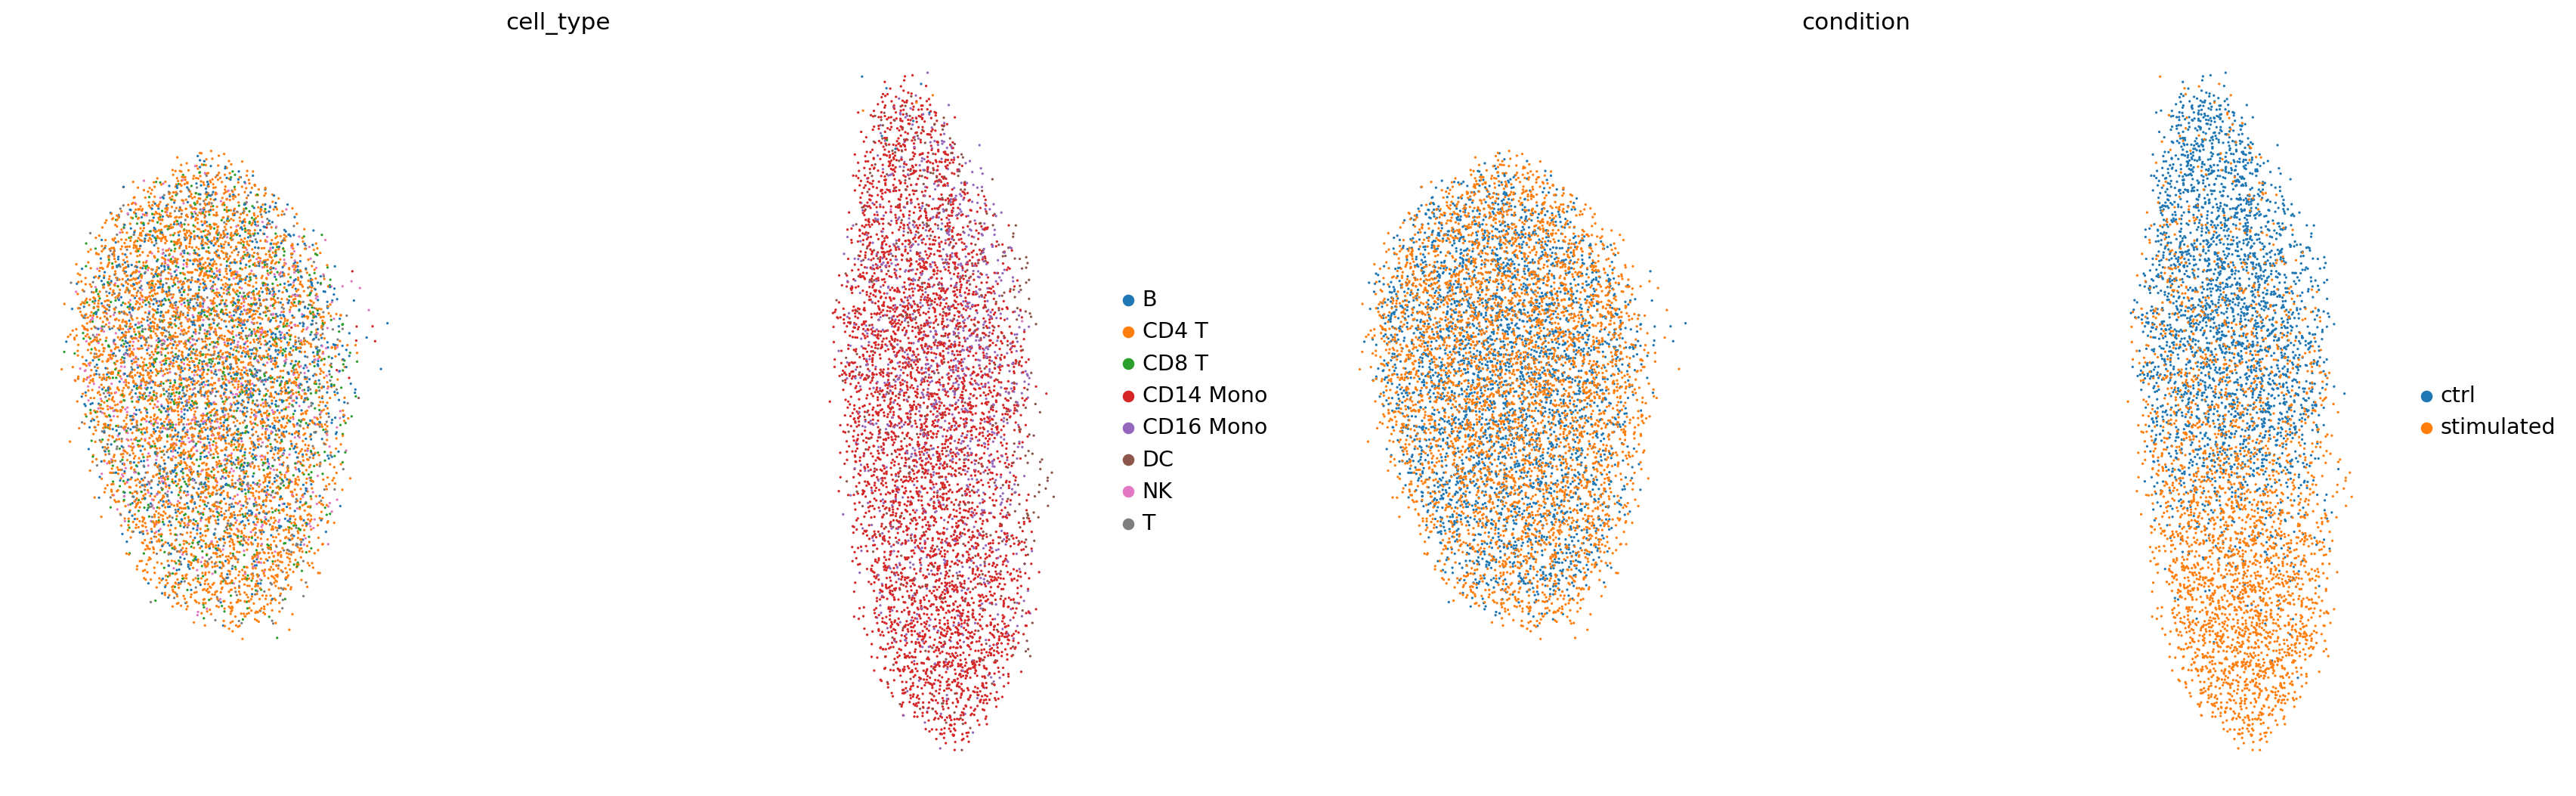

---UMAP for CellDISECT_Z_cell_type---


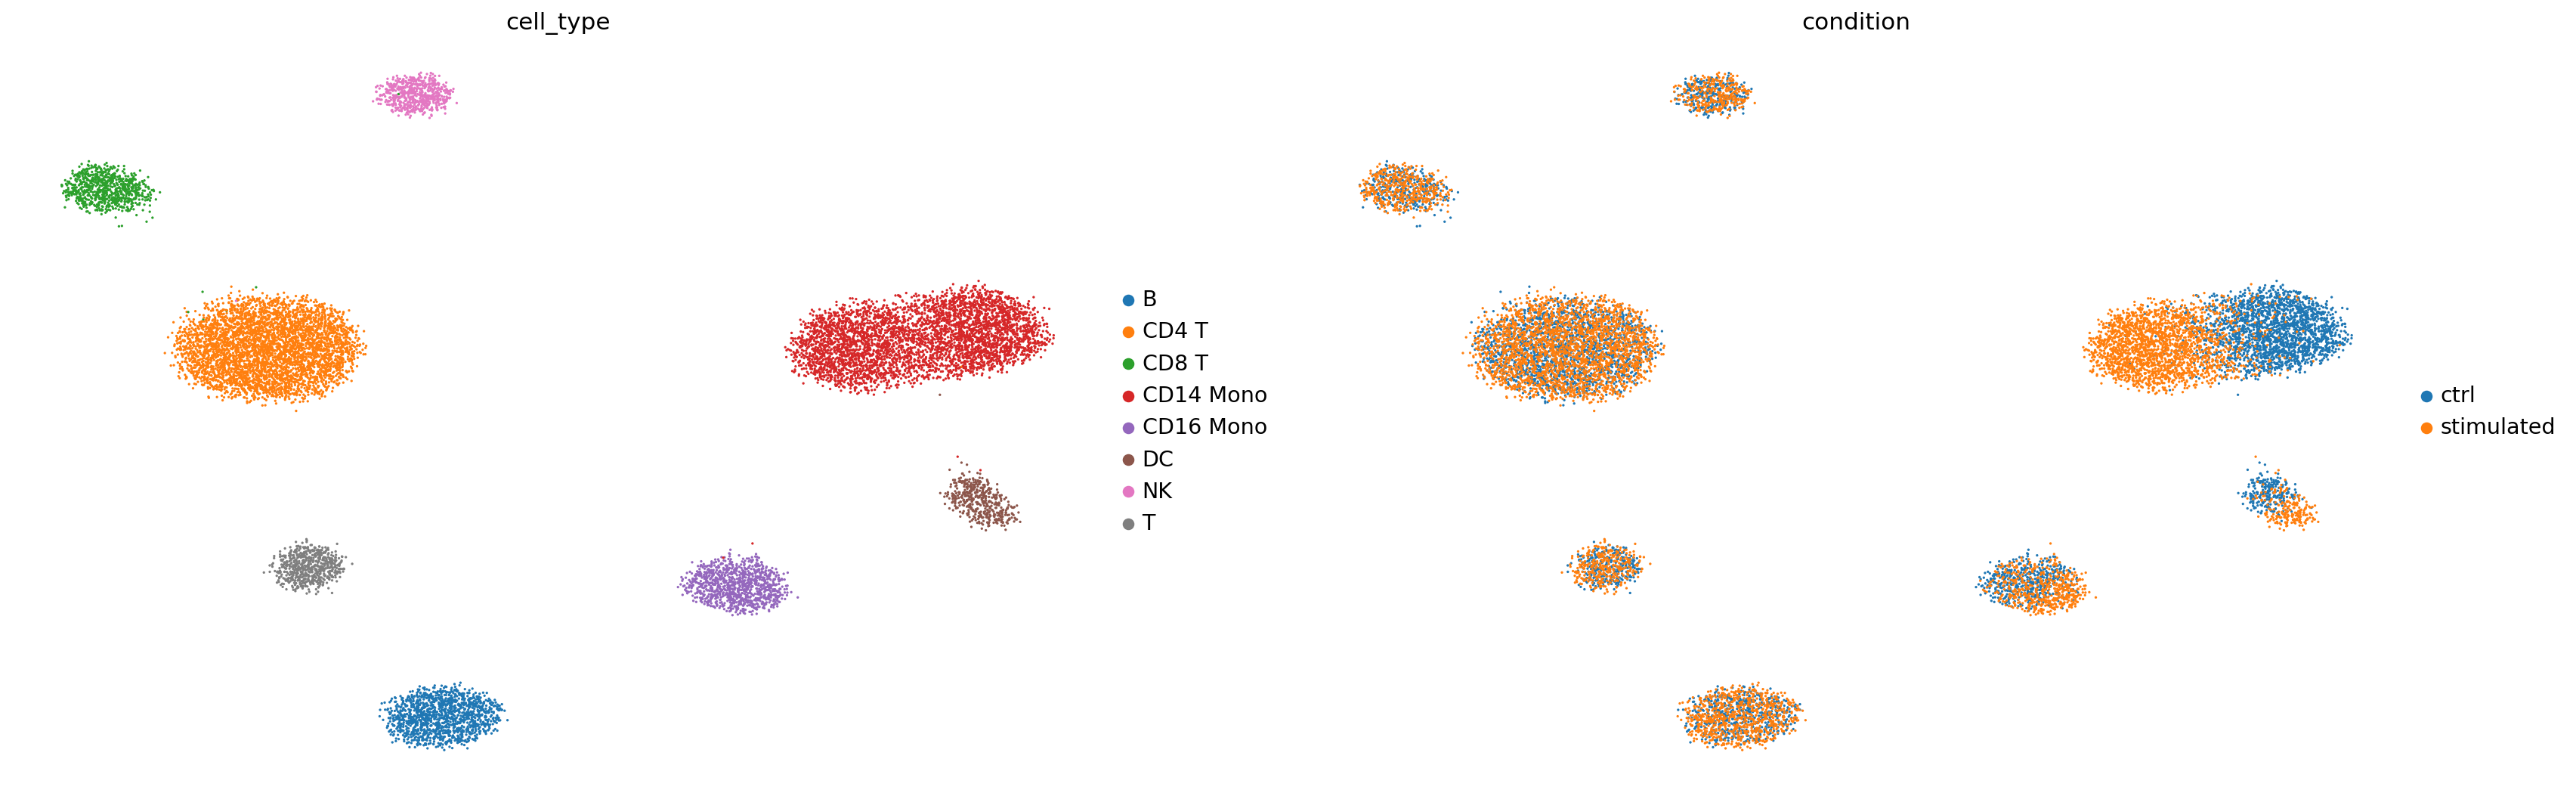

---UMAP for CellDISECT_Z_condition---


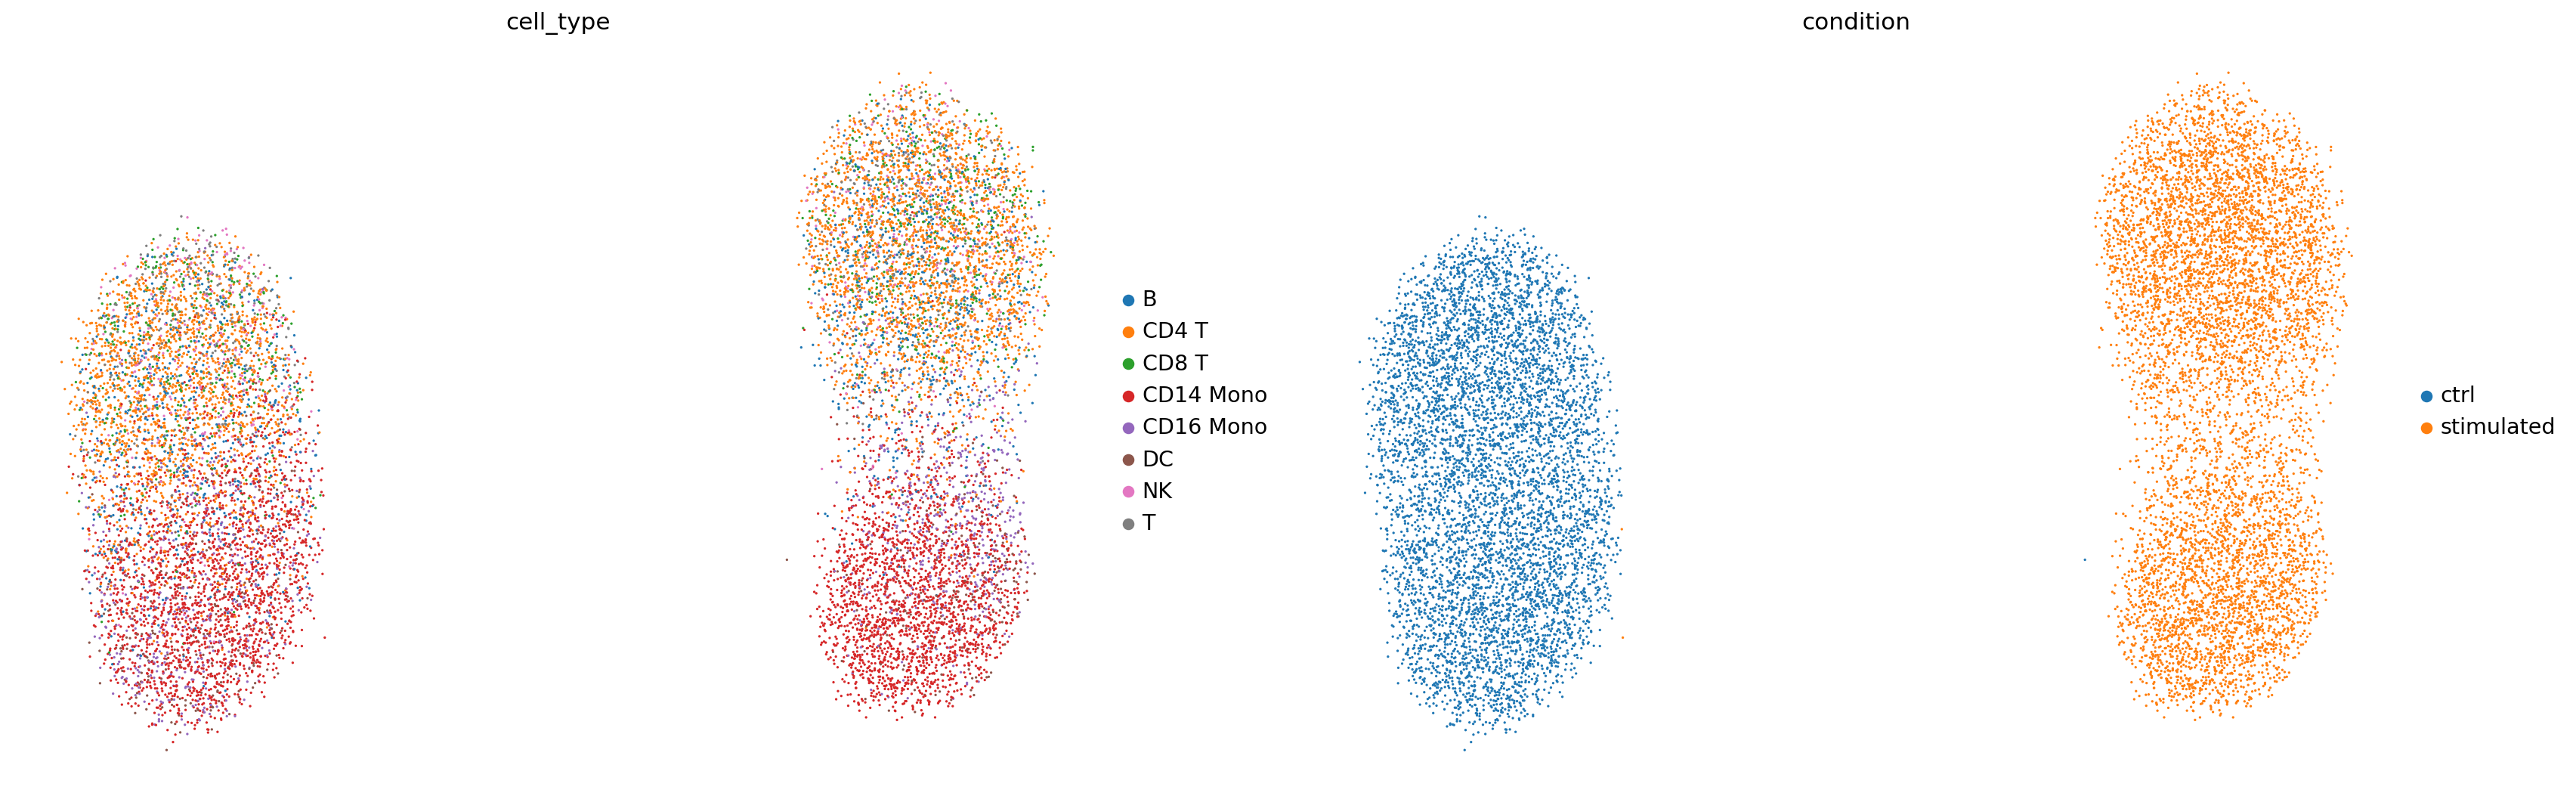

In [20]:
# Plotting Z_i
colors = cats
# colors = cats + ['any_other_obs_key']

for i in range(len(cats) + 1):  # loop over all Z_i
    if i == 0:
        latent_name = f'CellDISECT_Z_{i}'
    else:
        label = cats[i-1]
        latent_name = f'CellDISECT_Z_{label}'


    print(f"---UMAP for {latent_name}---")
    sc.set_figure_params(figsize=(12, 8))
    sc.pl.embedding(
        adata,
        f'{latent_name}_umap',
        color=colors,
        ncols=len(colors),
        frameon=False,
        # legend_loc=None, # Uncomment this line if you want to remove the legend
        # wspace=0.2,
    )


In [21]:
myeloid_lineage = ['CD14 Mono', 'CD16 Mono', 'DC']
lymphoid_lineage = ['CD4 T', 'CD8 T', 'T', 'B', 'NK']

adata.obs.loc[adata.obs['cell_type'].isin(myeloid_lineage), 'lineage'] = 'myeloid'
adata.obs.loc[adata.obs['cell_type'].isin(lymphoid_lineage), 'lineage'] = 'lymphoid'
adata.obs['lineage'].head()

index
AAACATACATTTCC.1     myeloid
AAACATACCAGAAA.1     myeloid
AAACATACCTCGCT.1     myeloid
AAACATACGATGAA.1    lymphoid
AAACATACGGCATT.1     myeloid
Name: lineage, dtype: object

You can see the discovery of underlying effects such as different cell type lineages in Z0

---UMAP for CellDISECT_Z_0---


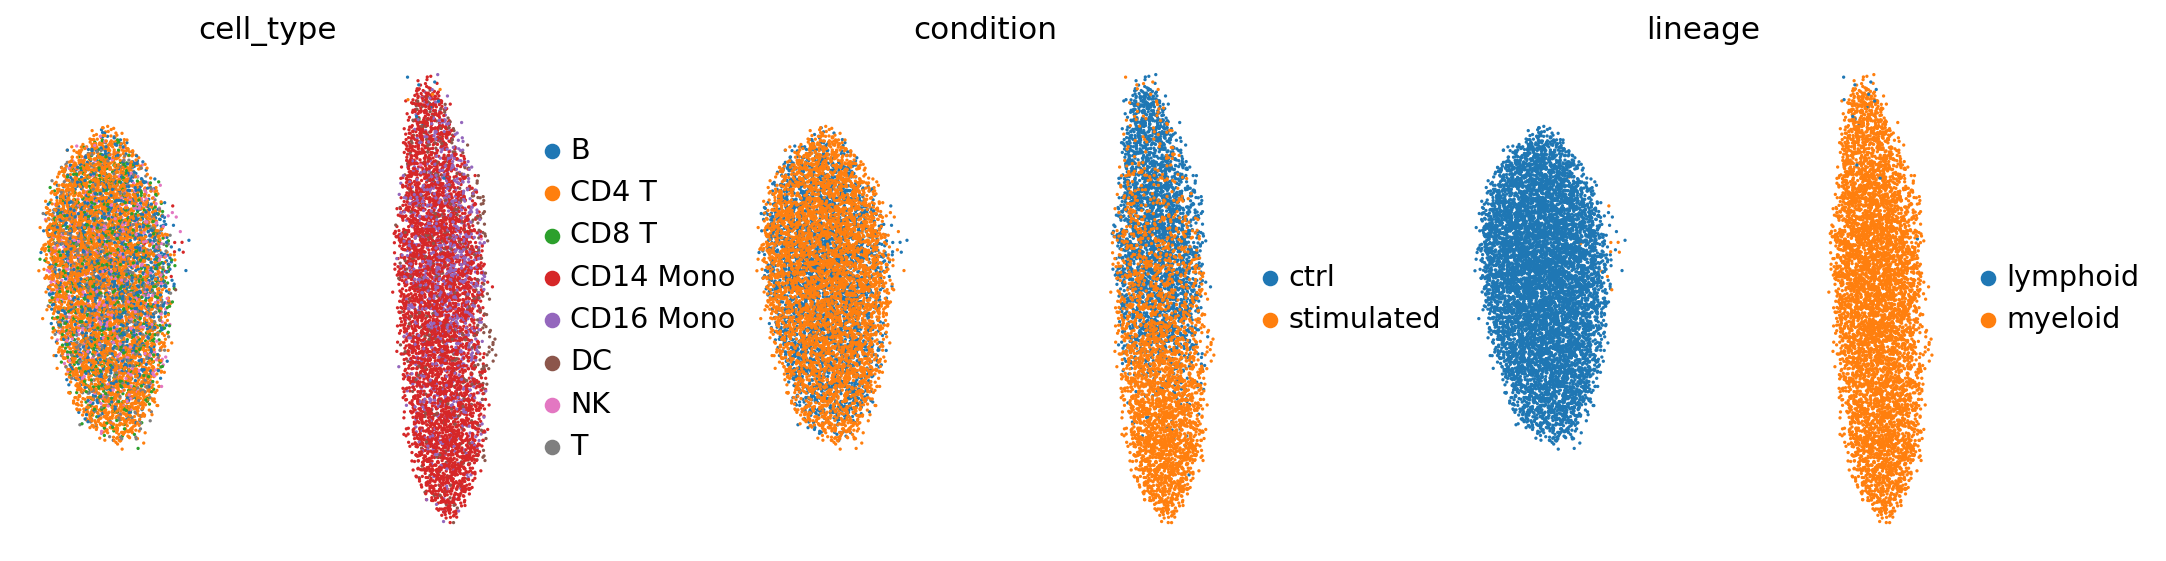

In [22]:
# Plotting Z_i
colors = cats
# colors = cats + ['any_other_obs_key']

i = 0
latent_name = f'CellDISECT_Z_{i}'


print(f"---UMAP for {latent_name}---")
# sc.set_figure_params(figsize=(12, 8))
sc.set_figure_params()
sc.pl.embedding(
    adata,
    f'{latent_name}_umap',
    color=colors + ['lineage'],
    ncols=len(colors)+1,
    frameon=False,
    # legend_loc=None, # Uncomment this line if you want to remove the legend
    wspace=0.3,
)


Let's explore counterfactual predictions

In [23]:
# Getting top Differentially Expressed Genes in each cell type with respect to control vs stimulated condition
adata.X = adata.layers['counts'].copy()
sc.pp.log1p(adata)
adata.obs['cov_condition'] = adata.obs['cell_type'].astype(str) + '_' + adata.obs.condition.astype(str)

groupby='cov_condition'
control_group='ctrl'
key_added="rank_genes_groups"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}
covariate = 'cell_type'
cov_categories = adata.obs[covariate].unique()
for cov_cat in cov_categories:
    print(cov_cat)
    # name of the control group in the groupby obs column
    control_group_cov = "_".join([cov_cat, control_group])
    adata_cov = adata[adata.obs[covariate] == cov_cat]

    sc.tl.rank_genes_groups(
        adata_cov,
        groupby=groupby,
        reference=control_group_cov,
        rankby_abs=rankby_abs,
        n_genes=n_genes,
        use_raw=False,
        method='wilcoxon',
    )

    de_genes_groups = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"]).columns

    de_genes = {}
    lfc = {}
    for group in de_genes_groups:
        de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['names']
        lfc[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['logfoldchanges']

        lfc_indices = lfc[group].abs().sort_values(ascending=False).index
        de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)

        gene_dict[group] = de_genes[group].tolist()

adata.uns[key_added] = gene_dict
adata.X = adata.layers['counts'].copy()

CD14 Mono
CD4 T
T
CD8 T
B
DC
CD16 Mono
NK


We have `CD14 Mono cells` as out of distribution in the model we trained. i.e. the Stimulated T cells have never been seen in the training process.

We want to predict counterfactual expressions of what control T cells would look like, given they were stimulated.

In [24]:
adata[adata.obs['cell_type'] == 'CD14 Mono'].obs['condition'].value_counts()

condition
ctrl          2215
stimulated    2147
Name: count, dtype: int64

In [25]:
x_ctrl, x_true, x_pred = model.predict_counterfactuals(
    adata[adata.obs['cell_type'] == 'CD14 Mono'].copy(), # We want to change T cells
    cov_names = ['condition'], # We want to change their condition
    cov_values = ['ctrl'], # We want to change the control cells
    cov_values_cf = ['stimulated'], # We want to change them to stimulated
    cats = cats,
    n_samples_from_source = None,
    seed = 42,
)
x_ctrl, x_true, x_pred = np.log1p(x_ctrl), np.log1p(x_true), np.log1p(x_pred)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [26]:
x_ctrl.shape, x_true.shape, x_pred.shape

(torch.Size([2215, 5000]), torch.Size([2147, 5000]), torch.Size([2215, 5000]))

In [27]:
deg_list = adata.uns["rank_genes_groups"][f'CD14 Mono_stimulated']

for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]

    pearson_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))
    deltaPearson_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))

    if n_top_deg is not None:
        print(f'Top {n_top_deg} DEGs:')
    else:
        print(f'All highly varaible genes ({adata.shape[1]}):')

    print(f"Pearson correlation: {pearson_mean_deg[0]:.3f}")
    print(f"Delta Pearson correlation: {deltaPearson_mean_deg[0]:.3f}")
    print()

Top 20 DEGs:
Pearson correlation: 0.905
Delta Pearson correlation: 0.894

All highly varaible genes (5000):
Pearson correlation: 0.915
Delta Pearson correlation: 0.778



In [28]:
obs = ['ctrl']*x_ctrl.shape[0] + ['true']*x_true.shape[0] + ['x_CellDISECT']*x_pred.shape[0]
from anndata import AnnData
import torch
results_adata = AnnData(X=torch.concat([x_ctrl, x_true, x_pred]).numpy(),
                        obs={'source': obs},
                        var=adata.var)

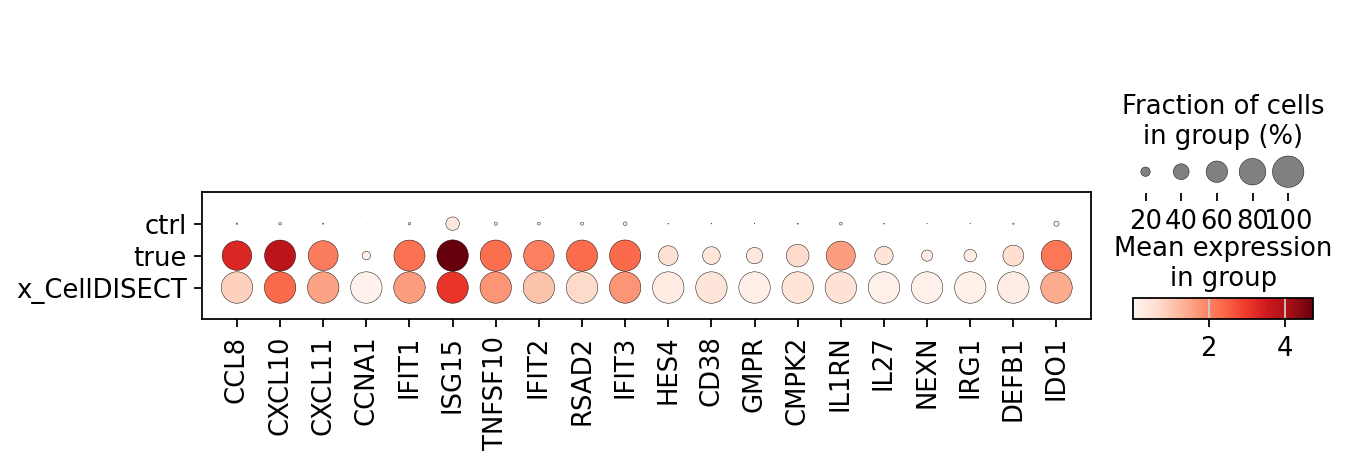

In [29]:
sc.pl.dotplot(results_adata, var_names=deg_list[:20], groupby="source", show=True, swap_axes=False)